# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Feature Selection](#Feature-Selection)
- [Variance Inflation Factor based Selection](#Variance-Inflation-Factor-based-Selection)
- [Pipeline Building](#Pipeline-Building)
- [Baseline Modeling](#baseline-modeling)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction

#### Building Basic Linear Models
- We begin with a basic model to establish a benchmark for future, more complex models
    
#### Day 2: Baseline Modeling

## Importing Libraries

In [130]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [131]:
train_data=pl.read_csv("train_preprocessed.csv")
test_data=pl.read_csv("test_preprocessed.csv")
train_data.shape,test_data.shape

((140, 24), (61, 24))

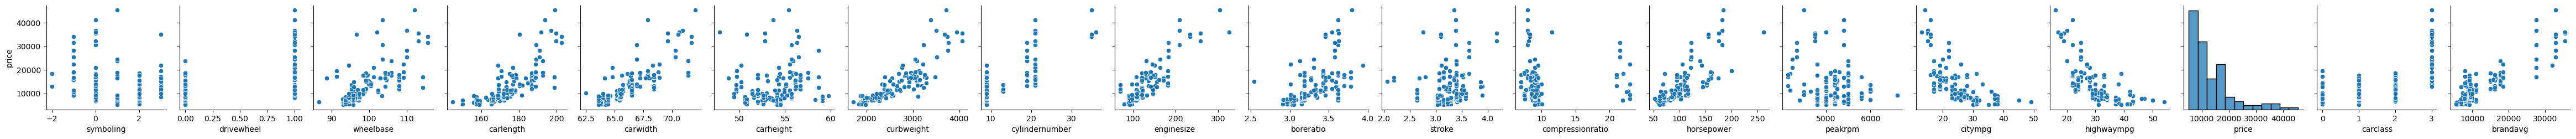

In [132]:
sns.pairplot(train_data.drop("car_ID").to_pandas(),y_vars=["price"])
plt.show()

In [133]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Feature selection

<Axes: >

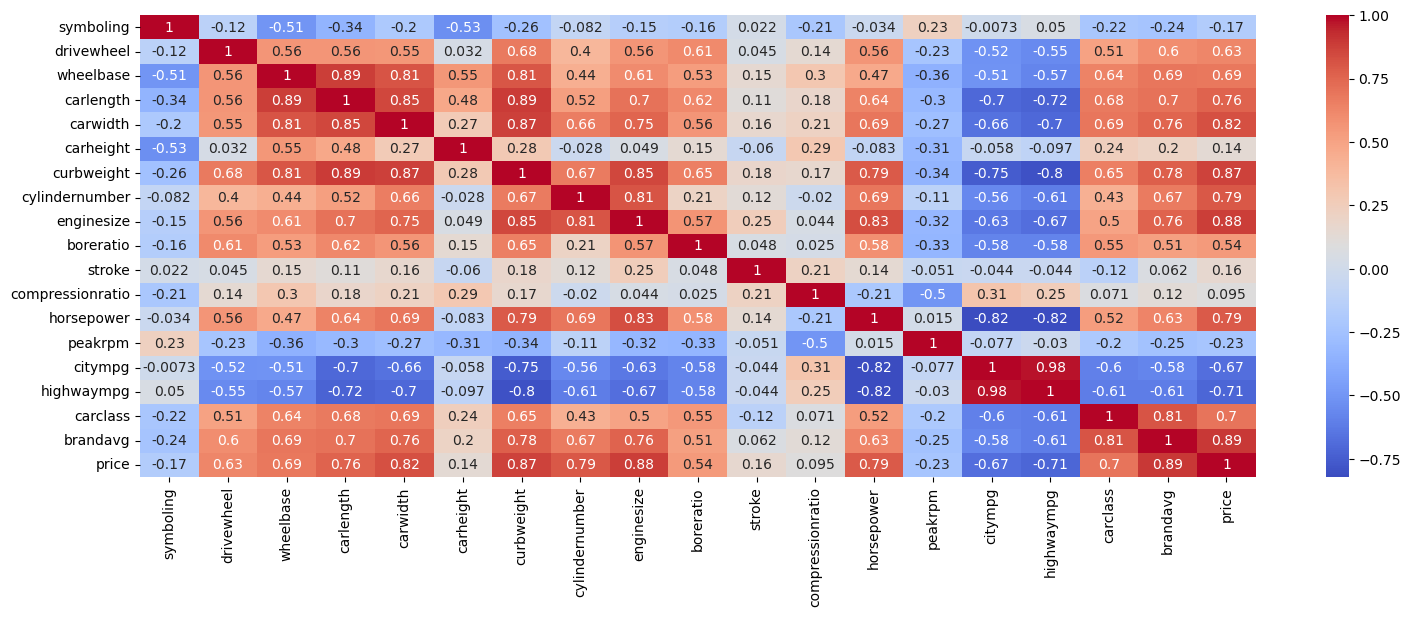

In [134]:
plt.figure(figsize=(18,6))
sns.heatmap(train_data[num_cols+["price"]].to_pandas().corr(),annot=True,cmap="coolwarm")

Dropping multicollinear features 0.85 threshold

In [135]:
train_data=train_data.drop(["carlength","carwidth","wheelbase","compressionratio","citympg"])
test_data=test_data.drop(["carlength","carwidth","wheelbase","compressionratio","citympg"])
to_remove = {"carlength","carwidth", "wheelbase", "compressionratio", "citympg"}

num_cols = list(set(num_cols) - to_remove)

# Variance inflation factor based selection

Dropping Based on variance inflation factor

In [136]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].drop("price","car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2980.106296
7,enginesize,16.339283
12,curbweight,11.221362
5,horsepower,8.265288
3,brandavg,7.647531


In [137]:
train_data=train_data.drop("enginesize")
test_data=test_data.drop("enginesize")
num_cols.remove("enginesize")
df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2944.544337
11,curbweight,10.218084
5,horsepower,5.998573
3,brandavg,5.973640
7,highwaympg,5.657931


In [138]:
train_data=train_data.drop("curbweight")
test_data=test_data.drop("curbweight")
num_cols.remove("curbweight")
df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2887.561368
3,brandavg,5.646873
5,horsepower,5.150765
7,highwaympg,4.624885
1,carclass,4.016654


# Pipeline Building

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['symboling', 'drivewheel',
                                                   'carheight',
                                                   'cylindernumber',
                                                   'boreratio', 'stroke',
                                                   'horsepower', 'peakrpm',
                                                   'highwaympg', 'carclass',
                                                   'brandavg'])])),
                ('lr', LinearRegression())])

# Baseline Modeling

Mean Train Score: 0.9293184298501282
Standard Deviation of Train Scores: 0.005040554114731749
Mean Test Score: 0.861152684608868
Standard Deviation of Test Scores: 0.08581911519370876
Mean absolute Error: 2034.3301416622564
R-squared on holdout set: 0.778694561591063
Adjusted R-squared on holdout set: 0.7049260821214173


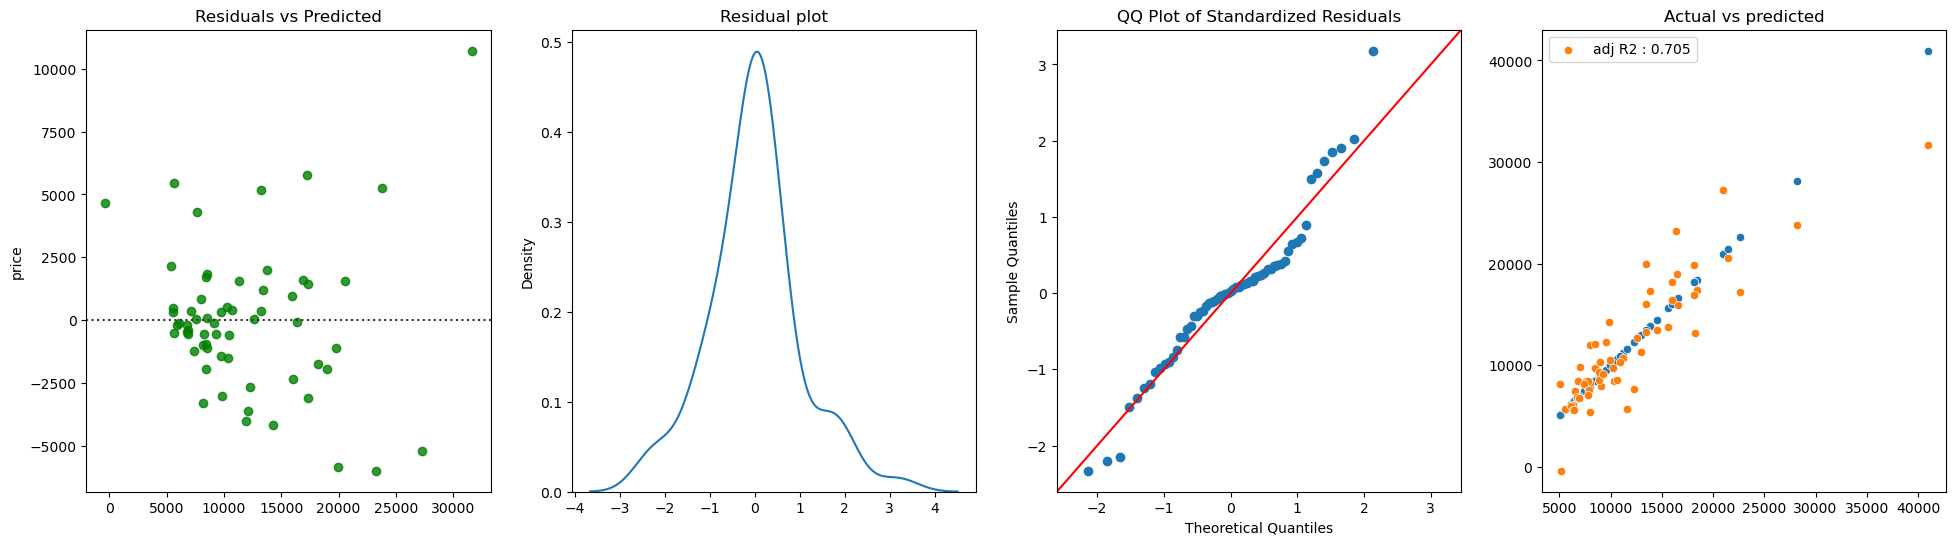

In [140]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2',return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

# Results

## Model Performance Summary (Day 2)

### Cross-Validation Results

* **Mean Train Score**: 0.9293 (decreased slightly from Day 1: 0.9412)
* **Standard Deviation of Train Scores**: 0.0050 (similar to Day 1: 0.0047)
* **Mean Test Score**: 0.8612 (increased from Day 1: 0.8517)
* **Standard Deviation of Test Scores**: 0.0858 (decreased from Day 1: 0.0981)

### Holdout Set Performance

* **Mean Absolute Error (MAE)**: 2034.33 (improved significantly from Day 1: 2704.44)
* **R-squared (R²)**: 0.7787 (increased substantially from Day 1: 0.6129)
* **Adjusted R-squared**: 0.7049 (increased significantly from Day 1: 0.3889)

### Insights and Comparison with Day 1

#### Improvements

* **Consistency**: The model's performance on unseen data improved. The mean test score increased from **0.8517** on Day 1 to **0.8612** on Day 2, and the standard deviation of test scores decreased from **0.0981** to **0.0858**. This indicates increased consistency across folds.
* **Error Magnitude**: The model's predictions are closer to the actual values. The MAE significantly decreased from **2704.44** on Day 1 to **2034.33** on Day 2, signifying a reduction in average prediction error.
* **Holdout Set R²**: The model explains a larger portion of the variance in the holdout data. The R² on the holdout set increased from **0.6129** on Day 1 to **0.7787** on Day 2, indicating a notable improvement in explanatory power.
* **Adjusted R²**: Accounting for the number of predictors, the model explains a higher percentage of the variance. The adjusted R² on the holdout set increased from **0.3889** on Day 1 to **0.7049** on Day 2, suggesting better performance while considering model complexity.

#### Observations

* **Overfitting**: The gap between the mean train score (0.9293) and the mean test score (0.8612) might still be present, suggesting potential for some degree of overfitting. However, compared to Day 1 (0.9412 vs 0.8517), the difference is smaller, suggesting a possible reduction in overfitting.
* **Model Stability**: The decrease in the standard deviation of both train and test scores indicates improved stability and reliability of the model across different training and testing splits.

**Note:** This report highlights the improvements and observations for Day 2 compared to Day 1 results.

# Conclusion

- Overall, the model has shown notable improvements in terms of prediction accuracy, consistency, and explanatory power from Day 1 to Day 2, indicating positive progress in the model training process.